# Hands on : Train fully supervised NN on the ADC2021 Challenge dataset

In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc
import sys
sys.path.insert(0, '../scripts/')

2022-09-27 06:33:39.499633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [2]:
from func import load_model, save_model, SetStyle
SetStyle()

## Load background dataset

In [3]:
dataset_folder = "/eos/atlas/atlascerngroupdisk/phys-exotics/hqt/mltutorial2022/"
bkg_file = 'BKG_dataset.h5'

In [4]:
# make sure input data has correct input shape - background training data
with h5py.File(dataset_folder+bkg_file, 'r') as file:
    X_train_bkg = np.array(file['X_train'])
    X_test_bkg = np.array(file['X_test'])
    X_val_bkg = np.array(file['X_val'])

In [5]:
print(X_train_bkg.shape)
print(X_test_bkg.shape)
print(X_val_bkg.shape)

(640000, 57)
(200000, 57)
(160000, 57)


## Load Signal ($A \to 4 \ell$) dataset

In [6]:
Ato4lsig_file = 'Ato4l_lepFilter_13TeV_dataset.h5'

In [7]:
with h5py.File(dataset_folder+Ato4lsig_file, 'r') as file:
    ato4l_sig = np.array(file['Data'])


In [8]:
X_train_sig = ato4l_sig[:45000, :]
X_test_sig = ato4l_sig[45000:, :]

## Visualize the Dataset

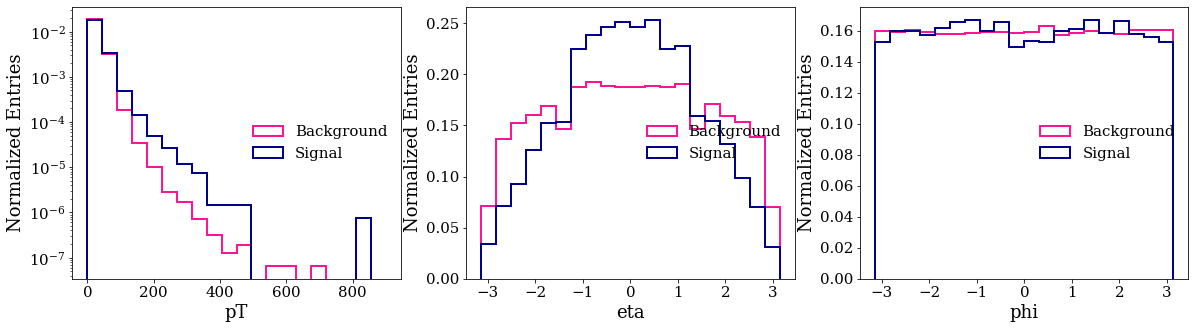

In [9]:
#Let's plot some histograms
plt.figure(figsize=(20,5))
logy_dict = {'pT':True,'eta':False,'phi':False}
plot_range = {'pT':(0,900), 'eta': (-3.14, 3.14), 'phi': (-3.14, 3.14)}
for i,name in enumerate(logy_dict):
    plt.subplot(1,3,i+1)
    to_plot=X_train_bkg[:,3+i]
    to_plot=to_plot[to_plot!=0]
    plt.hist(to_plot.flatten(),label="Background", bins = 20, range = plot_range[name], density = True, histtype='step', fill=False, linewidth=2, color="deeppink")
    
    
    to_plot_sig=X_train_sig[:,3+i]
    to_plot_sig=to_plot_sig[to_plot_sig!=0]
    plt.hist(to_plot_sig.flatten(),label="Signal", bins = 20, range = plot_range[name], density = True, histtype='step', fill=False, linewidth=2, color="darkblue")
    
    if logy_dict[name]:plt.yscale('log')
    plt.xlabel(name)
    plt.ylabel("Normalized Entries")
    plt.legend(loc='center right')

## Prepare training and testing dataset

In [10]:
X_train = np.concatenate((X_train_bkg, X_train_sig))
y_train = np.concatenate((np.zeros(len(X_train_bkg)),np.ones(len(X_train_sig))))

np.random.seed(1)

indices = np.array(range(len(X_train))).astype('int')
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

In [11]:
X_test = np.concatenate((X_test_bkg, X_test_sig))
y_test = np.concatenate((np.zeros(len(X_test_bkg)),np.ones(len(X_test_sig))))

## Define the Classifier Model

In [12]:
def classifier_model():    
    model = tf.keras.Sequential()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.add(layers.Dense(64,input_dim = 57,activation ='relu'))
#     model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu', kernel_regularizer=regularizers.L1(0.0001)))
#     model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
#     model.add(layers.Dropout(0.1))
    # model.add(layers.Dense(64,activation = 'relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [13]:
def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=2, color="darkblue")
    plt.plot(history.history['val_loss'], linewidth=2, color="crimson")
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
#     plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")

## Train the Classifier

In [14]:
def train_classifier():
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-5, mode='min', verbose=1, patience=10)

    best_model = tf.keras.callbacks.ModelCheckpoint('classifier.h5', verbose=1, save_best_only=True)
    history = classifier.fit(X_train, y_train, epochs=70, batch_size=512,validation_split = 0.2,callbacks=[best_model], verbose = 1) #validation_data=(X_val, y_val)
    learningCurveLoss(history)

2022-09-27 06:33:56.894457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_fo

Epoch 1/70
1066/1071 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9821
Epoch 1: val_loss improved from inf to 0.07669, saving model to classifier.h5
1071/1071 [==============================] - 6s 5ms/step - loss: 0.0886 - accuracy: 0.9821 - val_loss: 0.0767 - val_accuracy: 0.9840
Epoch 2/70
1061/1071 [============================>.] - ETA: 0s - loss: 0.0724 - accuracy: 0.9843
Epoch 2: val_loss improved from 0.07669 to 0.06874, saving model to classifier.h5
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0725 - accuracy: 0.9843 - val_loss: 0.0687 - val_accuracy: 0.9843
Epoch 3/70
1069/1071 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9848
Epoch 3: val_loss improved from 0.06874 to 0.06348, saving model to classifier.h5
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0649 - accuracy: 0.9848 - val_loss: 0.0635 - val_accuracy: 0.9847
Epoch 4/70
1064/1071 [============================>.] - ETA: 0s -

1071/1071 [==============================] - 5s 5ms/step - loss: 0.0494 - accuracy: 0.9864 - val_loss: 0.0516 - val_accuracy: 0.9855
Epoch 29/70
1063/1071 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9864
Epoch 29: val_loss improved from 0.05118 to 0.05115, saving model to classifier.h5
1071/1071 [==============================] - 5s 5ms/step - loss: 0.0491 - accuracy: 0.9864 - val_loss: 0.0512 - val_accuracy: 0.9856
Epoch 30/70
1066/1071 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9864
Epoch 30: val_loss did not improve from 0.05115
1071/1071 [==============================] - 5s 5ms/step - loss: 0.0490 - accuracy: 0.9864 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 31/70
1065/1071 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9864
Epoch 31: val_loss did not improve from 0.05115
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0489 - accuracy: 0.9864 - val_loss: 0.0514 - val_accuracy:

1058/1071 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9869
Epoch 57: val_loss did not improve from 0.05060
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0475 - accuracy: 0.9869 - val_loss: 0.0511 - val_accuracy: 0.9856
Epoch 58/70
1059/1071 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9869
Epoch 58: val_loss did not improve from 0.05060
1071/1071 [==============================] - 4s 4ms/step - loss: 0.0474 - accuracy: 0.9869 - val_loss: 0.0512 - val_accuracy: 0.9857
Epoch 59/70
1057/1071 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9869
Epoch 59: val_loss did not improve from 0.05060
1071/1071 [==============================] - 5s 5ms/step - loss: 0.0474 - accuracy: 0.9869 - val_loss: 0.0509 - val_accuracy: 0.9855
Epoch 60/70
1058/1071 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9869
Epoch 60: val_loss did not improve from 0.05060
1071/1071 [==============

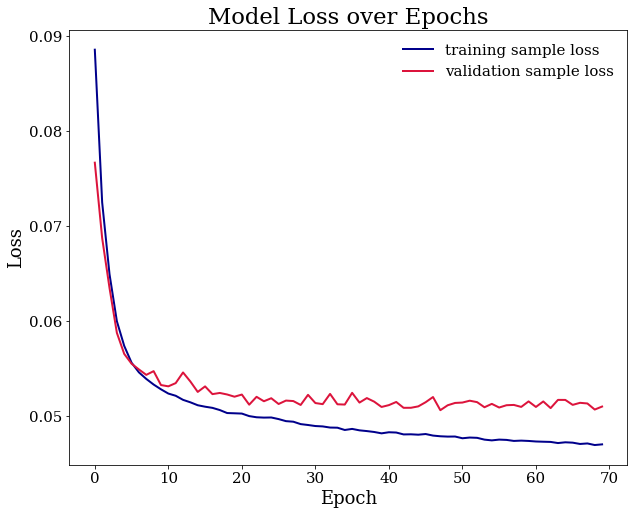

In [15]:
train_classifier()


## Test Model performance

In [16]:
trained_model = tf.keras.models.load_model('classifier.h5')

y_pred = trained_model.predict(X_test)
y_pred = y_pred.reshape(-1,)

pred_sig = []; pred_bkg = []
for i, true_label in enumerate(y_test):
    if true_label == 1:
        pred_sig.append(y_pred[i])
    else:
        pred_bkg.append(y_pred[i])

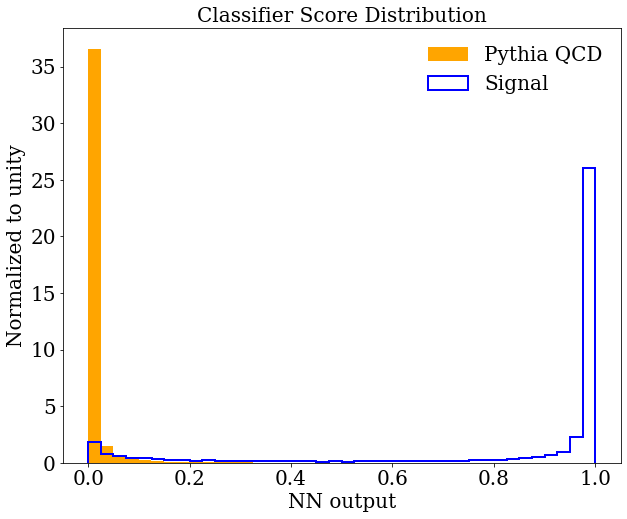

In [17]:
fig = plt.figure(figsize=(10, 8))
plt.hist(pred_bkg, bins=40, density = True, color='orange', label='Pythia QCD')
plt.hist(pred_sig, bins=40, histtype = "step", density = True, linewidth=2, color='b', label='Signal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel('NN output', fontsize=20)
plt.ylabel('Normalized to unity', fontsize=20)
plt.title('Classifier Score Distribution', fontsize=20)
plt.legend(frameon=False,fontsize=20)


0.9864406484182697
[0.9864406484182697]
[array([0.        , 0.01321907, 0.01331024, ..., 1.        , 1.        ,
       1.        ])]


NameError: name 'pl' is not defined

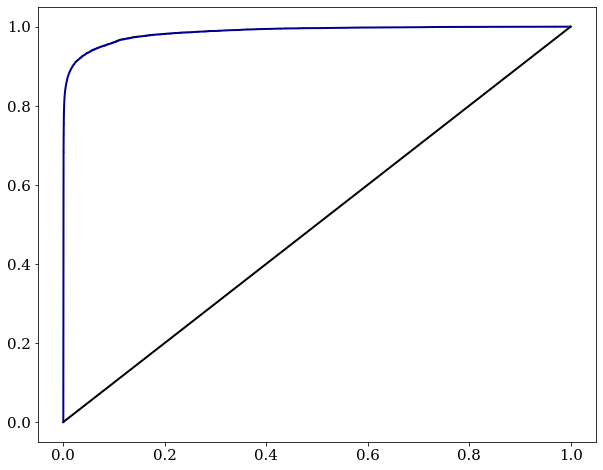

In [18]:
auc_list = []
tpr_list = []
fpr_list = []
y_pred = trained_model.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = auc(fpr,tpr)
auc_list.append(auc_value)
fpr_list.append(fpr)
tpr_list.append(tpr)

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.), linewidth=2, color="darkblue")
plt.plot([0, 1], [0, 1], 'k-')
print(auc_value)
print(auc_list)
print(tpr_list)
pl|t.semilogy()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(tpr_list[0], tpr_list[0]/np.sqrt((fpr_list[0])), label='Background vs Signal', linewidth=2, color="crimson")
# plt.plot(tpr_list[0][10:], (tpr_list[0][10:])/(np.sqrt(fpr_list[0][10:])))
plt.plot(tpr_list[0], tpr_list[0]/np.sqrt(tpr_list[0]), color="black",ls=":", label='Random')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Signal Rate', fontsize=20)
plt.ylabel('$\epsilon_{s}/\sqrt{\epsilon_{B}}$', fontsize=20)
#plt.title('Significance improvement curve', fontsize=20)
plt.legend(frameon=False,fontsize=20)